# Lab 11 - Finding the Rumor Source

In this lab, you will learn how to design **message passing** algorithms to locate the source of a rumor in a given network. 

After filling this notebook and running all the cells, rename the file **lab11.ipynb** to **netid_lab11.ipynb**, include your **well commented** code, and submit it by email. Avoid unneeded steps/computations and make sure your code runs before submitting it. Grading is based on your submission which is due at **9 p.m. Nov 28, 2017**. There is no late policy. No late submissions will be accepted.

**You will need the following functions from Lab 10.**

In [21]:
%matplotlib inline
from pylab import *
import random as rnd
import networkx as nx
from __future__ import division

rcParams['figure.figsize'] = 12, 12  # that's default image size for this interactive session

def draw_graph(graph, labels=None, graph_layout='shell',
               node_size=1600, node_color='blue', node_alpha=0.3,
               node_text_size=12,
               edge_color='blue', edge_alpha=0.3, edge_tickness=1,
               edge_text_pos=0.3,
               text_font='sans-serif'):
    """ 
    Based on: https://www.udacity.com/wiki/creating-network-graphs-with-python
    We describe a graph as a list enumerating all edges.
    Ex: graph = [(1,2), (2,3)] represents a graph with 2 edges - (node1 - node2) and (node2 - node3)
    """
    
    # create networkx graph
    G=nx.Graph()

    # add edges
    for edge in graph:
        G.add_edge(edge[0], edge[1])

    # these are different layouts for the network you may try
    # shell seems to work best
    if graph_layout == 'spring':
        graph_pos=nx.spring_layout(G)
    elif graph_layout == 'spectral':
        graph_pos=nx.spectral_layout(G)
    elif graph_layout == 'random':
        graph_pos=nx.random_layout(G)
    else:
        graph_pos=nx.shell_layout(G)

    # draw graph
    nx.draw_networkx_nodes(G,graph_pos,node_size=node_size, 
                           alpha=node_alpha, node_color=node_color)
    nx.draw_networkx_edges(G,graph_pos,width=edge_tickness,
                           alpha=edge_alpha,edge_color=edge_color)
    nx.draw_networkx_labels(G, graph_pos,font_size=node_text_size,
                            font_family=text_font)
    # show graph
    plt.show()
    
def build_adjacency(filename, min_degree, num_nodes):
    
    adjacency = [[] for i in range(num_nodes)]
    
    f = open(filename, 'r')
    # determine the degree number for each node
    for line in f.readlines():
        u, v, _, _  = map(int, line.split())
        # index from 1 in the file but from 0 in the list
        u -= 1
        v -= 1
        if u < num_nodes and v < num_nodes:
            adjacency[u].append(v)
            adjacency[v].append(u)
        if u >= num_nodes:
            break
    f.close()
    num_degrees = map(len, adjacency)
    filter_nodes = filter(lambda x: len(adjacency[x]) < min_degree, range(num_nodes))
    for i, neighbor in enumerate(adjacency):
        # if this node has less than min_degree neighbors
        if i in filter_nodes:
            neighbor = []
        # remove all nodes that has less than min_degree neighbors from current neighbors
        else:
            neighbor = filter(lambda x: x not in filter_nodes, neighbor)
        adjacency[i] = neighbor
    return adjacency

def adjacency_to_graph(adjacency):
    graph = []
    for u, neighbor in enumerate(adjacency):
        u += 1
        for v in neighbor:
            v += 1
            if v >= u: # avoid duplicate since u is in v's neighbor and v is in u's neighbor
                graph.append((u, v))            
    return graph

def generate_source(adjacency):
    while True:
        source = rnd.randint(0, len(adjacency) - 1)
        if len(adjacency[source]) > 0:
            break
    return source

def si_model_rumor_spreading(source, adjancency, N):
    infected_nodes = [-1]*N;
    who_infected = [[] for i in range(N)]
    
    # adding the source node to the list of infected nodes
    infected_nodes[0] = source
    
    for i in range(1,N):
        
        # update the set of susceptible_nodes and its corresponding source
        susceptible_nodes = []
        source_indices = []
        for source_new_idx, source_original_idx in enumerate(infected_nodes[:i]):
            neighbors = adjacency[source_original_idx]
            for neighbor in neighbors:
                # only susceptible when it's not infected yet
                if neighbor not in infected_nodes:
                    susceptible_nodes.append(neighbor)
                    source_indices.append(source_new_idx)
        
        # randomly generated a node from the set of all susceptible nodes
        rnd_idx = rnd.randrange(len(susceptible_nodes))
        to_be_infected_node_original_index = susceptible_nodes[rnd_idx]
        source = source_indices[rnd_idx]
        # store its original index in the infected_nodes
        infected_nodes[i] = to_be_infected_node_original_index
        # update the subgraph
        who_infected[i] = [source]
        who_infected[source].append(i)


    return who_infected, infected_nodes
    

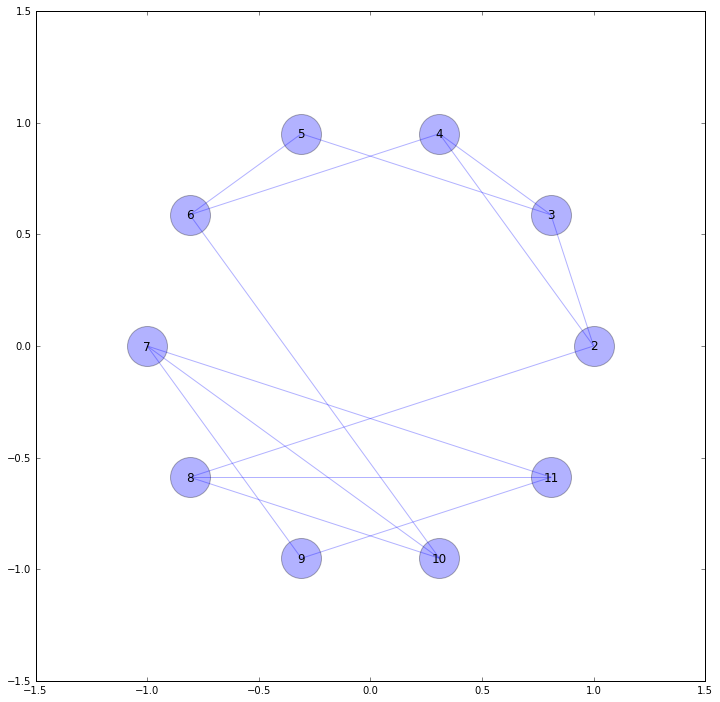

In [22]:
adjacency = [ [] for i in range(11)]
adjacency[0] = []
adjacency[10] = [6, 7, 8]
adjacency[1] = [2, 3, 7]
adjacency[2] = [1, 3, 4]
adjacency[9] = [5, 6, 7]
adjacency[3] = [1, 2, 5]
adjacency[4] = [2, 5]
adjacency[5] = [3, 9]
adjacency[6] = [8, 9, 10]
adjacency[7] = [1, 9, 10]
adjacency[8] = [6, 10]
adjacency[9] = [5, 6, 7]

graph = adjacency_to_graph(adjacency)
draw_graph(graph)


----

## Problem 0: Graph Traversal (0 pts)

Assume that you are given the adjacency list of a tree. Choose any node in the adjacency list to be the root of the tree. Write down a function called `upward_pass` that accepts the adjacency list and root node as arguments and does the following. It uses a recursive depth first search (DFS) traversal algorithm to pass messages from the leaf nodes up to the root node. The leaf nodes should pass 1 to their parent nodes. Intermediate nodes should sum the incoming messages, increment the sum by 1, and then pass the final result to their parent node. The algorithm stops whenever you hit the chosen root node. The function should return the list of values that were passed by each node in the tree.

In [23]:
def message_passing_up(up_messages, who_infected, parent_node, current_node):
    # root:
    if current_node == parent_node:
        for child_node in who_infected[current_node]:
            up_messages = message_passing_up(up_messages, who_infected, current_node, child_node)
    elif len(who_infected[current_node]) == 1:
    # leaf
        up_messages[parent_node] += 1
    else:
        for child_node in who_infected[current_node]:
            if child_node != parent_node:
                up_messages = message_passing_up(up_messages, who_infected, current_node, child_node)
        up_messages[parent_node] += up_messages[current_node]
    return up_messages
        
# creating a toy graph (tree)
adjacency = [ [] for i in range(7)]
adjacency[0] = [1, 2]
adjacency[1] = [0, 3, 4]
adjacency[2] = [0, 5, 6]
adjacency[3] = [1]
adjacency[4] = [1]
adjacency[5] = [2]
adjacency[6] = [2]

root_node = 6 # can use any arbitrary index for the root node
up_messages = [1]*len(adjacency) 
messages = message_passing_up(up_messages, adjacency, root_node, root_node)
print messages

[4, 3, 6, 1, 1, 1, 7]


----

## Problem 1: Rumor Centrality (35 pts)

Use the code provided in problem 0 to complete the functions below.

In [24]:
import random
import math
def rumor_centrality_up(up_messages_t, up_messages_p, who_infected, parent_node, current_node):
    
    # your code goes here
    if current_node == parent_node:
        for child_node in who_infected[current_node]:
            up_messages_t, up_messages_p = rumor_centrality_up(up_messages_t, up_messages_p, who_infected, current_node, child_node)
    elif len(who_infected[current_node]) == 1:
    # leaf
        up_messages_t[parent_node] += 1
        up_messages_p[parent_node] = up_messages_t[parent_node] * up_messages_p[current_node]    # Update parent node p-value
    else:
        # Call rumor centrality up function on all neighbors apart from the parent node of the current node
        for child_node in who_infected[current_node]:
            if child_node != parent_node:
                up_messages_t, up_messages_p = rumor_centrality_up(up_messages_t, up_messages_p, who_infected, current_node, child_node)
        up_messages_t[parent_node] += up_messages_t[current_node]
        temp_product = 1
        # Update p-value of current node with information from neighboring nodes
        for neighbor in who_infected[current_node]:
            temp_product *= up_messages_p[neighbor]
        up_messages_p[current_node] = up_messages_t[current_node] * temp_product
        
    return up_messages_t, up_messages_p

    

def rumor_centrality_down(down_messages, up_messages_t, up_messages_p, who_infected, parent_node, current_node):
    
    # your code goes here
    N = len(who_infected)
    # Calculation done at the root to find rumor value
    if current_node == parent_node:
        temp_product = 1
        # Multiply all the p-values of the children of the root
        for child_node in who_infected[current_node]:
            temp_product *= up_messages_p[child_node]
        r = math.factorial(N)//(N*temp_product)                   # Set the rumor value for the root
        down_messages[parent_node] = r
        for child_node in who_infected[parent_node]:
            down_messages = rumor_centrality_down(down_messages, up_messages_t, up_messages_p, who_infected, parent_node, child_node)
    else:
        # Set the rumor value for the current node based on the rumor value of the parent node and t-values of the current node
        down_messages[current_node] = down_messages[parent_node] * (up_messages_t[current_node])//(N - up_messages_t[current_node])
        for neighbor in who_infected[current_node]:
            if down_messages[neighbor] == -1:
                down_messages = rumor_centrality_down(down_messages, up_messages_t, up_messages_p, who_infected, current_node, neighbor)
                
                
    return down_messages 


def rumor_centrality(who_infected):
    
    root = 0           # arbitrary root
    # initialize the lists used in the two functions
    up_messages_p = [1]*len(who_infected)
    up_messages_t = [1]*len(who_infected)
    down_messages = [-1]*len(who_infected)
    
    # up_messages_t and up_messages_p will be populated with the correct values, which are then needed for down messages
    up_messages_t, up_messages_p = rumor_centrality_up(up_messages_t, up_messages_p, who_infected, root, root)
    down_messages = rumor_centrality_down(down_messages, up_messages_t, up_messages_p, who_infected, root, root)
    
    # Store the max message
    max_message = max(down_messages)
    
    # Find the nodes that have a message value equal to max message; append them to the rumor_centers list
    rumor_centers = []
    for i in range(len(down_messages)):
        if down_messages[i] == max_message:
            rumor_centers.append(i)
            
    # Choose one center at random and return it
    return random.choice(rumor_centers)
    # your code goes here


adjacency = [ [] for i in range(7)]
adjacency[0] = [1, 2]
adjacency[1] = [0, 3, 4]
adjacency[2] = [0, 5, 6]
adjacency[3] = [1]
adjacency[4] = [1]
adjacency[5] = [2]
adjacency[6] = [2]

root_node = 6

up_messages_p = [1]*len(adjacency)
up_messages_t = [1]*len(adjacency)
down_messages = [-1]*len(adjacency)

up_messages_t, up_messages_p = rumor_centrality_up(up_messages_t, up_messages_p, adjacency, root_node, root_node)
down_messages = rumor_centrality_down(down_messages, up_messages_t, up_messages_p, adjacency, root_node, root_node)

print up_messages_p
print up_messages_t
print down_messages

[12, 3, 72, 1, 1, 1, 1]
[4, 3, 6, 1, 1, 1, 7]
[80, 60, 60, 10, 10, 10, 10]


----

## Problem 3: Jordan Centrality (35 pts)

Use the code provided in problem 0 to complete the functions below.

In [25]:
import random
def jordan_centrality_up(up_messages, l1, l2, who_infected, parent_node, current_node):
    
    # your code goes here
    # At root, want to go down all the way to the leaves first
    if current_node == parent_node:
        for child_node in who_infected[parent_node]:
            up_messages, l1, l2 = jordan_centrality_up(up_messages,l1, l2, who_infected, current_node, child_node)
        # Calculation to get l1 and l2 values for the root
        temp_lengths = []
        for neighbor in who_infected[current_node]:
            temp_lengths.append(l1[neighbor] + 1)
        temp_lengths = sorted(temp_lengths, reverse=True)    # temp_lengths now contains the largest value at index 0 followed by 
        l1[current_node] = temp_lengths[0]                   # second largest value at index 1
        if len(temp_lengths) < 2:              # If the root only has one child, set l2 as 0
            l2[current_node] = 0
        else:
            l2[current_node] = temp_lengths[1]
    elif len(who_infected[current_node]) == 1:
    # leaf
        up_messages[parent_node] += 1
    else:
        for child_node in who_infected[current_node]:
            if child_node != parent_node:
                up_messages, l1, l2 = jordan_centrality_up(up_messages,l1, l2, who_infected, current_node, child_node)
        up_messages[parent_node] += up_messages[current_node]
        # Similar calculation as root to get l1 and l2 values for the current node
        temp_lengths = []
        for neighbor in who_infected[current_node]:
            if neighbor != parent_node:
                temp_lengths.append(l1[neighbor] + 1)
        temp_lengths = sorted(temp_lengths, reverse=True)
        l1[current_node] = temp_lengths[0]
        if len(temp_lengths) < 2:
            l2[current_node] = 0
        else:
            l2[current_node] = temp_lengths[1]
        
        
    return up_messages, l1, l2


def jordan_centrality_down(down_pass, l1, l2, who_infected, parent_node, current_node):
    
    # your code goes here
    if current_node == parent_node:
        if l1[current_node] - l2[current_node] <= 1:    # If the root is the Jordan Center, return the root
            return current_node
        for child_node in who_infected[parent_node]:
            j_center = jordan_centrality_down(l2[parent_node] + 1, l1, l2, who_infected, parent_node, child_node)
    else:
        # Update l2 of the next node in line as we go down the tree
        l2[current_node] = max(down_pass, l2[current_node])
        if (l1[current_node] - l2[current_node]) <= 1:      # If the current node is the jordan center, return the current node
                return current_node
        else:
            for child_node in who_infected[current_node]:
                if child_node != parent_node and l1[child_node] != 0:
                    j_center = jordan_centrality_down(l2[current_node] + 1, l1, l2, who_infected, current_node, child_node)
                 

    
    return j_center



def jordan_centrality(who_infected):
    
    jordan_center = -1
    
    #your code goes here
    up_messages = [1]*len(who_infected)
    l1 = [0]*len(who_infected)                 # l1 is the list to hold values of the longest length per node
    l2 = [0]*len(who_infected)                 # l2 is the list to hold the values of the second longest length per node
    
    root_node = 0   # Choose an arbitrary root node
    
    up_messages, l1, l2 = jordan_centrality_up(up_messages, l1, l2, who_infected, root_node, root_node)
    
    jordan_center = jordan_centrality_down(0, l1, l2, who_infected, root_node, root_node)
    
    return jordan_center


adjacency = [ [] for i in range(7)]
adjacency[0] = [1, 2]
adjacency[1] = [0, 3, 4]
adjacency[2] = [0, 5, 6]
adjacency[3] = [1]
adjacency[4] = [1]
adjacency[5] = [2]
adjacency[6] = [2]

root_node = 6

up_messages = [1]*len(adjacency)
l1 = [0]*len(adjacency)
l2 = [0]*len(adjacency)

up_messages, l1,l2 = jordan_centrality_up(up_messages, l1, l2, adjacency, root_node, root_node)

jordan_center = jordan_centrality_down(0, l1, l2, adjacency, root_node, root_node)

print l1
print l2
print jordan_center

[2, 1, 3, 0, 0, 0, 4]
[2, 1, 1, 0, 0, 0, 0]
0


----

## Problem 4: Putting it All Together (30 pts)

Use the function `buildDatasetGraph` with `filename = out.facebook-wosn-links`, `num_nodes = 4941`, and `min_degree = 3` to load Facebook's social network.  After loading the social network, use the SI spreading model developed in Lab 10 to generate an infected subgraph of size $N$ (a parameter that will be specified in a bit). Estimate the source of the rumor using both rumor centrality (Problem 2) and Jordan centrality (Problem 3). For each case, the estimated rumor source $\hat{v}$ can be compared to the true rumor source $v^*$ to determine whether the detection was correct or wrong. This process can be repeated 50 times in order to compute the **average probability of detection** $P_d(N)$ by counting the number of times we have $\hat{v}= v^*$ and dividing this number by 50.


Consider $N=10:10:500$ and then for
each $N$ compute $P_d(N)$ (as described above) for both rumor centrality and Jordan centrality. The notation $N = 10 : 10 : 500$ is borrowed from MATLAB. It means $N = 10, 20, 30, 40, ...., 500$. So, $N$ goes from 10 to 500 in increments of 10. Plot $P_d(N)$ as a
function of $N$ (all on the same
figure) on a log-log scale.

**The above simulations will take a while (at least one hour) so make
sure you run them well before the deadline.**

gay: 10
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
gay: 20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
gay: 30
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
gay: 40
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
gay: 50
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
gay: 60
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
gay: 70
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37


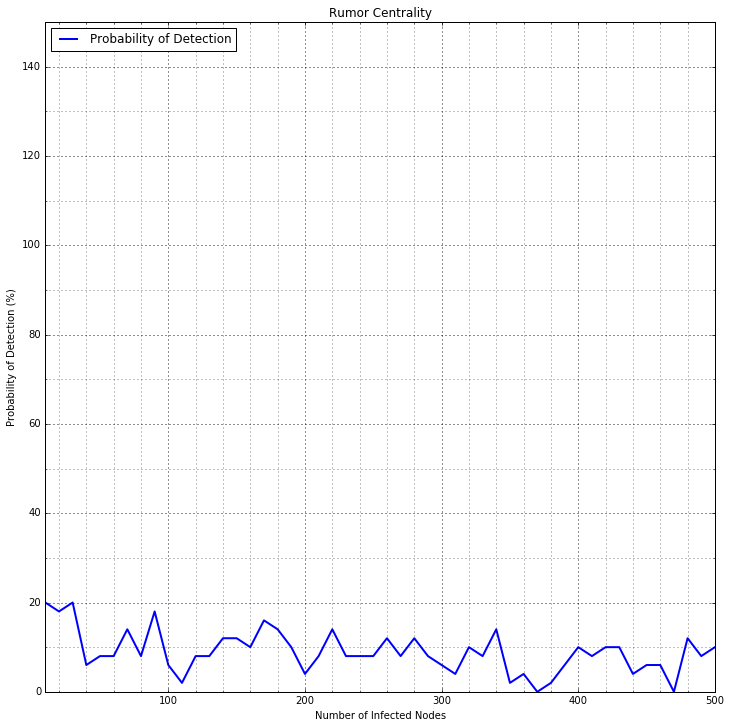

In [31]:
rnd.seed(233)

N_min = 10 # min number of nodes to infect
N_max = 500 # max number of nodes to infect
Inc = 10 # increment
L = 50 # number of trials

Pd_rumor = [] # initializing the detection probability list under rumor centrality to an empty list
Pd_jordan = [] # initializing the detection probability list under rumor centrality to an empty list
N_axis = []

# tweak this line to match the problem statement!
adjacency = build_adjacency('out.facebook-wosn-links', 3, 4941)
num_nodes = len(adjacency) # number of nodes in the underlying graph (this includes nodes with no neighbours)

for N in range(N_min, N_max + 1, Inc):
    N_axis.append(N)
    det_count = 0 # initializing the detection counter to zero
    jordan_errors = 0 # this will keep track of the number of errors under rumor centrality
    rumor_errors = 0 # this will keep track of the number of errors under Jordan centrality
    print "gay:", N
    for j in range(L):
        print j
        # select a rumor source at random
        source = generate_source(adjacency)  
        # spread the rumor to N people and return who_infected (the adjacency list of the infection tree)
        who_infected, infected_nodes = si_model_rumor_spreading(source, adjacency, N)
        # use rumor centrality to estimate the source
        rumor_center = infected_nodes[rumor_centrality(who_infected)]
        # figure out if rumor center = rumor source and update rumor_errors correspondingly
        if rumor_center == source:
            rumor_errors += 1
        # user Jordan centrality to estimate the source
        jordan_center = infected_nodes[jordan_centrality(who_infected)]
        # figure out if Jordan center = rumor source and update jordan_errors correspondingly
        if jordan_center == source:
            jordan_errors += 1
            
    Pd_rumor.append(float(rumor_errors)/L)
    Pd_jordan.append(float(jordan_errors)/L)

# tweak this code to (a) be a log-log plot and (b) include the jordan centrality probability of error
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
ax = plt.subplot(111)
plt.plot(N_axis, [y * 100 for y in Pd_rumor], lw = 2.0, label = "Probability of Detection")
plt.axis([N_min, N_max, 0, 150])
plt.xlabel("Number of Infected Nodes")
plt.ylabel("Probability of Detection (%)")
plt.legend(loc = "upper left")
plt.title("Rumor Centrality")
plt.grid(which = "minor")
plt.grid(which = "major")
ax.xaxis.set_minor_locator(MultipleLocator(20))
ax.yaxis.set_minor_locator(MultipleLocator(10))
plt.show()

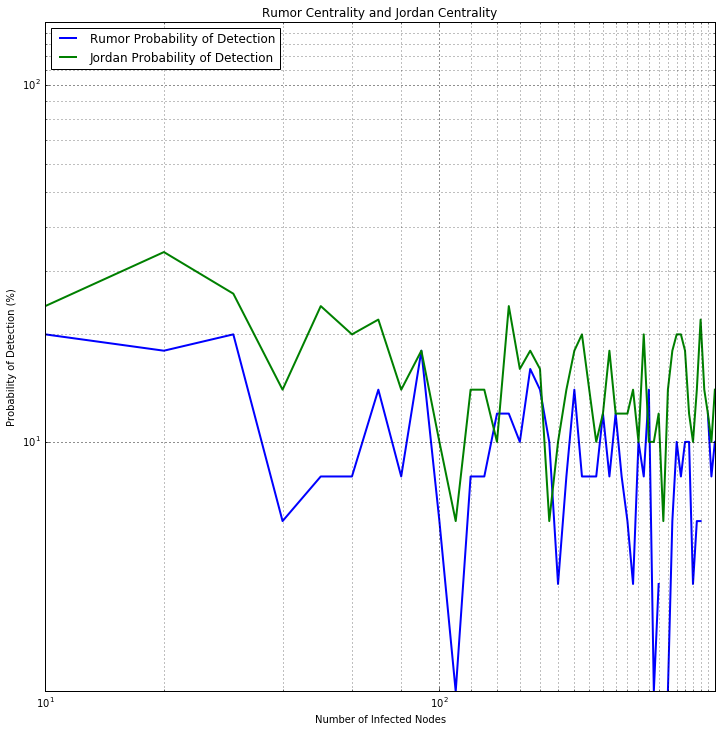

In [32]:
ax = plt.subplot(111)
plt.loglog(N_axis, [y * 100 for y in Pd_rumor], lw = 2.0, label = "Rumor Probability of Detection")
plt.loglog(N_axis, [y * 100 for y in Pd_jordan], lw = 2.0, label = "Jordan Probability of Detection")
plt.axis([N_min, N_max, 0, 150])
plt.xlabel("Number of Infected Nodes")
plt.ylabel("Probability of Detection (%)")
plt.legend(loc = "upper left")
plt.title("Rumor Centrality and Jordan Centrality")
plt.grid(which = "minor")
plt.grid(which = "major")
ax.xaxis.set_minor_locator(MultipleLocator(20))
ax.yaxis.set_minor_locator(MultipleLocator(10))
plt.show()

**Questions**

- How does $P_d(N)$ vary as a function of $N$ under Jordan and rumor centrality? Why? 
- Is Jordan centrality better than rumor centrality? Why? 

Pd(N) decreases as a function of N under both Jordan and Rumor centrality because as we infect more and more nodes, it becomes increasingly more difficult to identify the correct source

Jordan centrality is better than rumor centrality, as shown in the graph above. Also as the number of total nodes increases, each node can have many paths associated to it and it is not necessary that the node closest to the middle is the source. With Jordan centrality, it is a simpler calculation that works outwards - in and often times leads to only few nodes sharing the same Jordan length metrics.